In [1]:
import pandas as pd
import numpy as np
import os
import sys
import scanpy as sc
import anndata as ad
import scipy
import gget
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

# local 
sys.path.append("../")
import utils as ut

In [2]:
# load predictions
fpath = "/nfs/turbo/umms-indikar/shared/projects/MC3R/hypomap/merged_predictions.csv"
df = pd.read_csv(fpath)
print(f"{df.shape=}")

for c in df.columns:
    if not c == 'index':
        df[f'{c}_clean'] = df[c].apply(lambda x: x.split(":")[1]).astype(str)


# load clustering results
fpath = "/nfs/turbo/umms-indikar/shared/projects/MC3R/results/embedding.csv"
cdf = pd.read_csv(fpath)
print(f"{cdf.shape=}")

# merge 'em'
df = pd.merge(df, cdf, 
              how='left',
              left_on='index',
              right_on='index')


# clean-up the cell type
df = df.set_index('index')


print(f"{df.shape=}")
df.head()

df.shape=(43312, 5)
cdf.shape=(43312, 3)
df.shape=(43312, 10)


,reference_embedding_C7_named,reference_embedding_C25_named,C25_named,C7_named,reference_embedding_C7_named_clean,reference_embedding_C25_named_clean,C25_named_clean,C7_named_clean,UMAP1,UMAP2
index,,,,,,,,,,
AAACCCACATGGCTGC-1_fasted_m,C7-2: GABA,C25-11: GABA-1,C25-10: GABA-2,C7-2: GABA,GABA,GABA-1,GABA-2,GABA,-6.741960,14.083050
AAACCCAGTATATGGA-1_fasted_m,C7-2: GABA,C25-13: GABA-4,C25-1: GLU-1,C7-2: GABA,GABA,GABA-4,GLU-1,GABA,2.378481,2.956433
AAACCCAGTCAACACT-1_fasted_m,C7-5: Immune,C25-21: Immune,C25-21: Immune,C7-5: Immune,Immune,Immune,Immune,Immune,1.525248,-6.143299
AAACCCATCCCGTGAG-1_fasted_m,C7-4: Oligo+Precursor,C25-19: Oligodendrocytes,C25-19: Oligodendrocytes,C7-4: Oligo+Precursor,Oligo+Precursor,Oligodendrocytes,Oligodendrocytes,Oligo+Precursor,15.965842,14.408034
AAACCCATCGAACTCA-1_fasted_m,C7-1: GLU,C25-2: GLU-2,C25-2: GLU-2,C7-1: GLU,GLU,GLU-2,GLU-2,GLU,-2.045243,7.478702


In [3]:
dirpath = "/nfs/turbo/umms-indikar/shared/projects/MC3R/h5ad_files/"

data = {}

for f in os.listdir(dirpath):
    fullpath = f"{dirpath}{f}"
    key = f.replace(".h5ad", "")

    batch_andata = sc.read(fullpath)
    batch_andata.obs['batch'] = key
    data[key] = batch_andata
    
adata = ad.concat(data, index_unique="_") # combine all the experiments
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 43312 × 32285
    obs: 'batch'

In [4]:
# add the metadata into the object
adata.obs = adata.obs.join(df, 
                           how='left')

adata.obs['Diet'] = adata.obs['batch'].apply(lambda x: x.split("_")[0])
adata.obs['Sex'] = adata.obs['batch'].apply(lambda x: x.split("_")[1])

adata.obsm['X_umap'] = adata.obs[['UMAP1', 'UMAP2']].copy().to_numpy()

adata.obs.head()

,batch,reference_embedding_C7_named,reference_embedding_C25_named,C25_named,C7_named,reference_embedding_C7_named_clean,reference_embedding_C25_named_clean,C25_named_clean,C7_named_clean,UMAP1,UMAP2,Diet,Sex
AAACCCACATGGCTGC-1_fasted_m,fasted_m,C7-2: GABA,C25-11: GABA-1,C25-10: GABA-2,C7-2: GABA,GABA,GABA-1,GABA-2,GABA,-6.741960,14.083050,fasted,m
AAACCCAGTATATGGA-1_fasted_m,fasted_m,C7-2: GABA,C25-13: GABA-4,C25-1: GLU-1,C7-2: GABA,GABA,GABA-4,GLU-1,GABA,2.378481,2.956433,fasted,m
AAACCCAGTCAACACT-1_fasted_m,fasted_m,C7-5: Immune,C25-21: Immune,C25-21: Immune,C7-5: Immune,Immune,Immune,Immune,Immune,1.525248,-6.143299,fasted,m
AAACCCATCCCGTGAG-1_fasted_m,fasted_m,C7-4: Oligo+Precursor,C25-19: Oligodendrocytes,C25-19: Oligodendrocytes,C7-4: Oligo+Precursor,Oligo+Precursor,Oligodendrocytes,Oligodendrocytes,Oligo+Precursor,15.965842,14.408034,fasted,m
AAACCCATCGAACTCA-1_fasted_m,fasted_m,C7-1: GLU,C25-2: GLU-2,C25-2: GLU-2,C7-1: GLU,GLU,GLU-2,GLU-2,GLU,-2.045243,7.478702,fasted,m


In [5]:
"""some simple processing """

adata.layers["counts"] = adata.X.copy() # store the raw counts

""" Add a metadata column """
adata.obs['broad_type'] = adata.obs['reference_embedding_C25_named_clean'].apply(lambda x: x.split("-")[0])

sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_genes(adata, min_cells=10)
sc.pp.calculate_qc_metrics(adata)

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
# sc.pp.combat(adata) # regress out batch effects

sc.pp.highly_variable_genes(adata, 
                            min_mean=0.0125, 
                            max_mean=3, 
                            min_disp=0.5)

sc.tl.pca(adata, n_comps=25)

adata

AnnData object with n_obs × n_vars = 42937 × 25060
    obs: 'batch', 'reference_embedding_C7_named', 'reference_embedding_C25_named', 'C25_named', 'C7_named', 'reference_embedding_C7_named_clean', 'reference_embedding_C25_named_clean', 'C25_named_clean', 'C7_named_clean', 'UMAP1', 'UMAP2', 'Diet', 'Sex', 'broad_type', 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [6]:
"""A metdata columns for a few genes """

label_genes = [
    'Sun1',
    'Mc3r',
    'Agrp',
    'Pomc',
    'Lepr',
]

[print(x) for x in label_genes if not x in adata.var_names]

for gene in label_genes:
    mask = np.ravel(adata[:, [gene]].layers['counts'].todense() > 0)
    adata.obs[gene] = np.where(mask, 1, 0)
    adata.obs[gene] = adata.obs[gene].astype('category')
    print(f"-------- {gene} --------")
    print(adata.obs[gene].value_counts())
    print()

print('Done')

-------- Sun1 --------
1    21714
0    21223
Name: Sun1, dtype: int64

-------- Mc3r --------
0    42175
1      762
Name: Mc3r, dtype: int64

-------- Agrp --------
0    25432
1    17505
Name: Agrp, dtype: int64

-------- Pomc --------
0    31697
1    11240
Name: Pomc, dtype: int64

-------- Lepr --------
0    35836
1     7101
Name: Lepr, dtype: int64

Done


In [7]:
""" Sun1+ vs Sun1- for M3cr Cells """

sun = adata[adata.obs["Sun1"] == 1] 
sun.obs[['Diet', 'Sex', 'Sun1']].value_counts()
sun

View of AnnData object with n_obs × n_vars = 21714 × 25060
    obs: 'batch', 'reference_embedding_C7_named', 'reference_embedding_C25_named', 'C25_named', 'C7_named', 'reference_embedding_C7_named_clean', 'reference_embedding_C25_named_clean', 'C25_named_clean', 'C7_named_clean', 'UMAP1', 'UMAP2', 'Diet', 'Sex', 'broad_type', 'n_genes', 'Sun1', 'Mc3r', 'Agrp', 'Pomc', 'Lepr'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [8]:
sun.obs[['broad_type', 'Sun1']].value_counts()

broad_type          Sun1
 GLU                1       13075
 GABA               1        7400
 Oligodendrocytes   1         473
 Astrocytes         1         366
 OPC                1         145
 Ependymal          1         107
 Immune             1          71
 ParsTuber          1          33
 Mural+Endothelial  1          31
 Fibroblasts        1          13
dtype: int64

In [9]:
key = 'Diet'
# get marker genes
sc.tl.rank_genes_groups(sun, 
                        groupby=key,
                        method='wilcoxon',
                        key_added=key,
                        corr_method='benjamini-hochberg')

deg = sc.get.rank_genes_groups_df(sun, 
                                  group=None,
                                  key=key)

deg.head()

... storing 'batch' as categorical
... storing 'reference_embedding_C7_named' as categorical
... storing 'reference_embedding_C25_named' as categorical
... storing 'C25_named' as categorical
... storing 'C7_named' as categorical
... storing 'reference_embedding_C7_named_clean' as categorical
... storing 'reference_embedding_C25_named_clean' as categorical
... storing 'C25_named_clean' as categorical
... storing 'C7_named_clean' as categorical
... storing 'Diet' as categorical
... storing 'Sex' as categorical
... storing 'broad_type' as categorical


,group,names,scores,logfoldchanges,pvals,pvals_adj
0,fasted,Srsf10,41.279652,0.737619,0.000000e+00,0.000000e+00
1,fasted,Gm26871,35.457455,0.700850,2.226513e-275,1.115928e-271
2,fasted,Npy,34.957886,2.528843,9.827482e-268,4.104612e-264
3,fasted,Peg3,34.523144,0.468921,3.606546e-261,1.291143e-257
4,fasted,Mblac2,31.868235,0.753812,7.358846e-223,2.305159e-219


In [10]:
# break

In [11]:
n_print = 20
n_query = 300
alpha = 0.05
sig = deg[deg['pvals_adj'] <= alpha]

"""Up in female """
sigf = sig[sig['group'] == 'fasted']
sigf = sigf.sort_values(by='logfoldchanges', ascending=False)

print(f"----- Upregulated genes in Sun1+ cells (fasted) -----")
print(sigf[['names', 'logfoldchanges']].head(n_print))


"""Up in female """
sigm = sig[sig['group'] == 'fed']
sigm = sigm.sort_values(by='logfoldchanges', ascending=False)

print(f"----- Upregulated genes in Sun1+ cells (fed) -----")
print(sigm[['names', 'logfoldchanges']].head(n_print))

----- Upregulated genes in Sun1+ cells (fasted) -----
              names  logfoldchanges
4020        Slco1a1        5.951638
1051         Atp1a4        3.595480
4252           Hao1        2.898025
1947        Gm26510        2.634465
2               Npy        2.528843
2715        Gm47214        2.410792
3771          Ccl17        2.358620
4271          Tex35        2.297786
1816          Meiob        2.278723
2513        Gm20647        2.130400
541        Slc6a20a        2.096387
4003          Tigit        2.078757
470         Gm44577        2.073891
336           Casq1        2.029659
2091         Cdkn1a        2.006333
3269        Gm31456        1.958677
1047          Corin        1.884898
2132          Hmgb2        1.772249
2399  1700093K21Rik        1.748098
4288        Gm13544        1.735911
----- Upregulated genes in Sun1+ cells (fed) -----
               names  logfoldchanges
25061           Pomc        2.549356
26982           Insc        1.884588
26950  9330117O12Rik        

In [ ]:
break

# Volcano plots

In [12]:
def label_point(x, y, val, ax, offset=(0.0, 0.0)):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+ offset[0], point['y'] + offset[1], str(point['val']), fontsize=4,)

/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,names,scores,logfoldchanges,pvals,pvals_adj,log10p,color
4020,Slco1a1,2.819345,5.951638,4.812180e-03,2.048467e-02,2.317658,r
1051,Atp1a4,7.977112,3.595480,1.497966e-15,2.551940e-14,14.824498,r
4252,Hao1,2.579144,2.898025,9.904551e-03,3.940436e-02,2.004165,r
2,Npy,34.957886,2.528843,9.827482e-268,4.104612e-264,267.007558,r
3771,Ccl17,3.049252,2.358620,2.294119e-03,1.051017e-02,2.639384,r
4271,Tex35,2.562254,2.297786,1.039952e-02,4.117092e-02,1.982987,r
1816,Meiob,5.763302,2.278723,8.248386e-09,8.039850e-08,8.083631,r
541,Slc6a20a,10.723889,2.096387,7.862609e-27,2.616693e-25,26.104433,r
4003,Tigit,2.834501,2.078757,4.589733e-03,1.963111e-02,2.338213,r
336,Casq1,12.602570,2.029659,2.043765e-36,1.089718e-34,35.689569,r


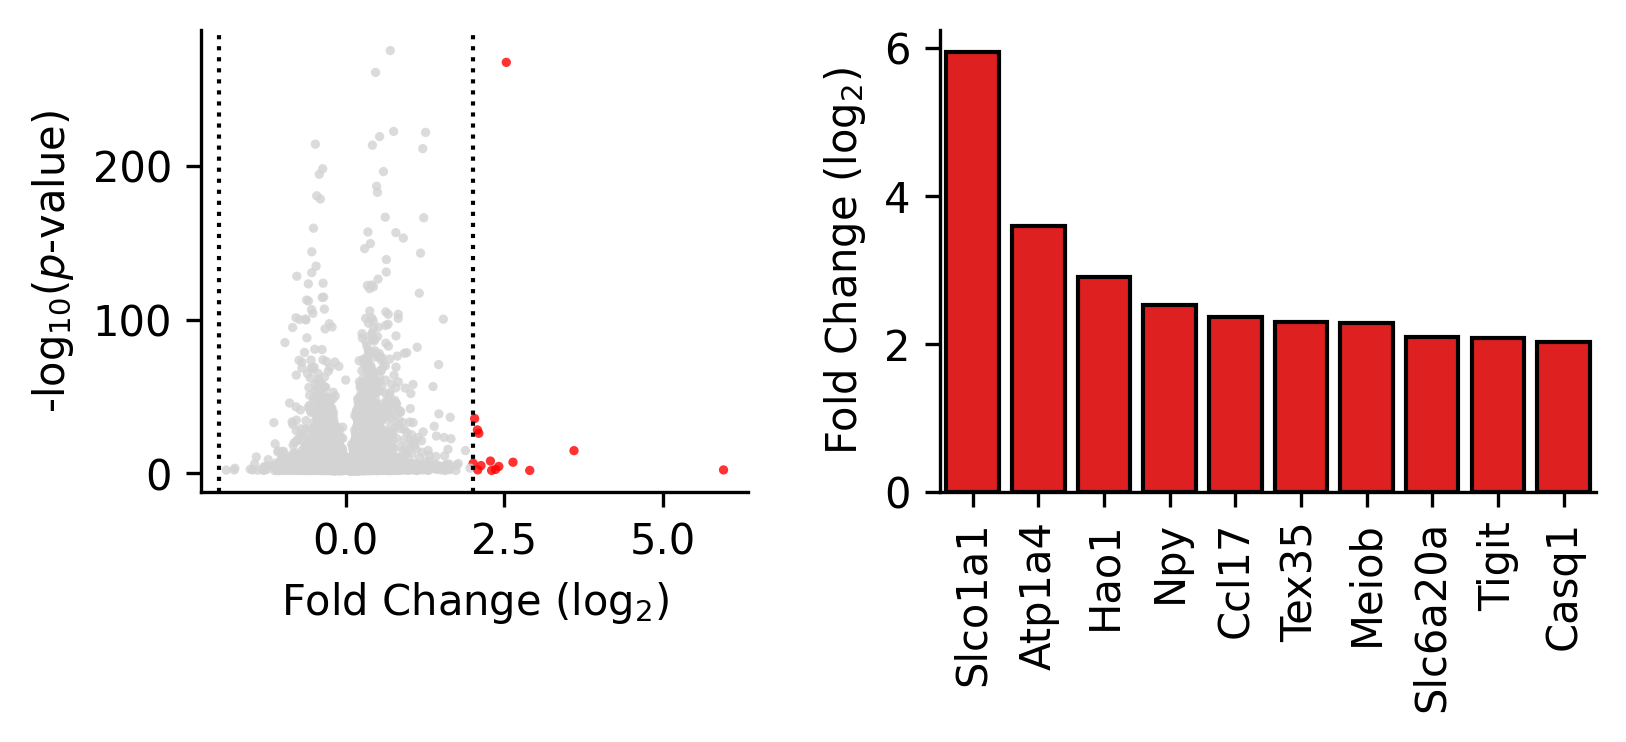

In [13]:
alpha = 0.05
plot_top = 10
lcft = 2

deg = sc.get.rank_genes_groups_df(sun, 
                                  group='fasted',
                                  key=key)

deg['log10p'] = -1 * np.log10(deg['pvals'])

deg = deg[deg['pvals_adj'] <= alpha]

deg['color'] = np.where(deg['logfoldchanges'] > lcft, 'r', 'lightgrey')

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 2

sns.scatterplot(data=deg, 
            x='logfoldchanges',
            y='log10p',
            ec='none',
            alpha=0.8,
            c=deg['color'].to_list(),
            zorder=1,
            s=5)

plt.ylabel(r"-log$_{10}$($p$-value)")
plt.xlabel(r"Fold Change (log$_{2}$)")

plt.axvline(x=2, lw=1, c='k', ls=':', zorder=2)
plt.axvline(x=-2, lw=1, c='k', ls=':', zorder=2)

hi_deg = deg[deg['logfoldchanges'] > lcft]
hi_deg = hi_deg[~hi_deg['names'].str.contains('Gm')]
hi_deg = hi_deg.sort_values(by='logfoldchanges', ascending=False)
hi_deg = hi_deg.head(plot_top)

divider = make_axes_locatable(plt.gca())
ax2 = divider.append_axes("right", size="120%", pad="35%")

sns.barplot(data=hi_deg,
            y='logfoldchanges',
            x='names',
            ec='k',
            color='r',
            ax=ax2)

ax2.set_ylabel(r"Fold Change (log$_{2}$)")
ax2.set_xlabel("")
ax2.tick_params(axis='x', rotation=90)

sns.despine()

hi_deg

/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


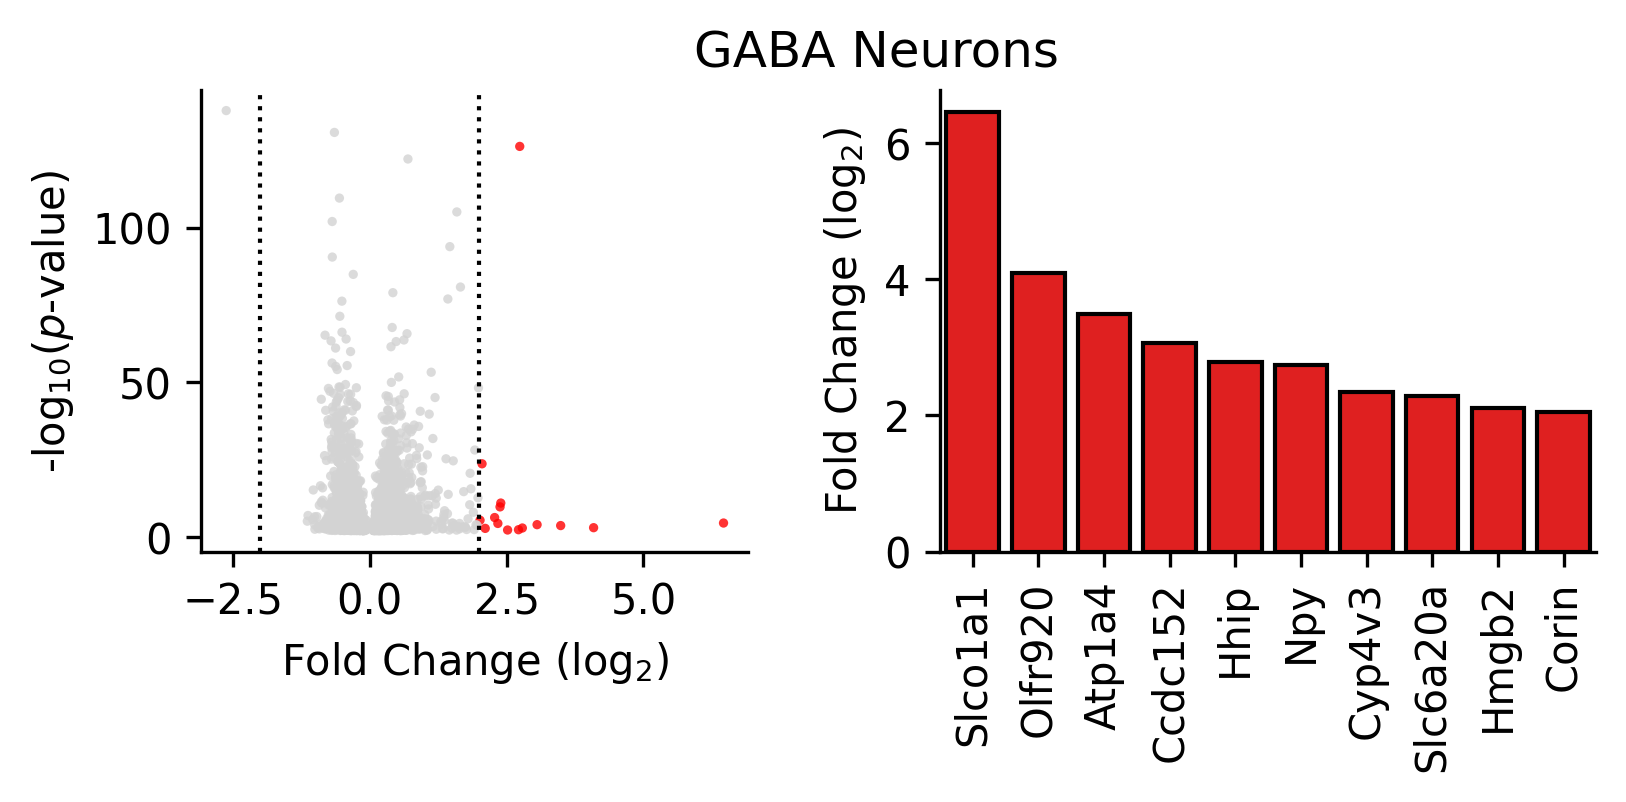

         names     scores  logfoldchanges          pvals      pvals_adj  \
1112   Slco1a1   4.202089        6.464522   2.644629e-05   3.318698e-04   
1560   Olfr920   3.337270        4.090250   8.460553e-04   7.539881e-03   
1321    Atp1a4   3.751313        3.488687   1.759107e-04   1.862409e-03   
1232   Ccdc152   3.918814        3.057374   8.898570e-05   1.006764e-03   
1614      Hhip   3.270622        2.788118   1.073112e-03   9.276365e-03   
0          Npy  23.975840        2.740673  4.969458e-127  3.113365e-123   
1145    Cyp4v3   4.133286        2.340799   3.576141e-05   4.358856e-04   
784   Slc6a20a   5.048440        2.282021   4.454335e-07   7.778790e-06   
1648     Hmgb2   3.191850        2.109720   1.413645e-03   1.188392e-02   
99       Corin  10.204308        2.051795   1.896701e-24   2.075604e-22   

          log10p color  
1112    4.577635     r  
1560    3.072601     r  
1321    3.754708     r  
1232    4.050680     r  
1614    2.969355     r  
0     126.303691     r  

/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


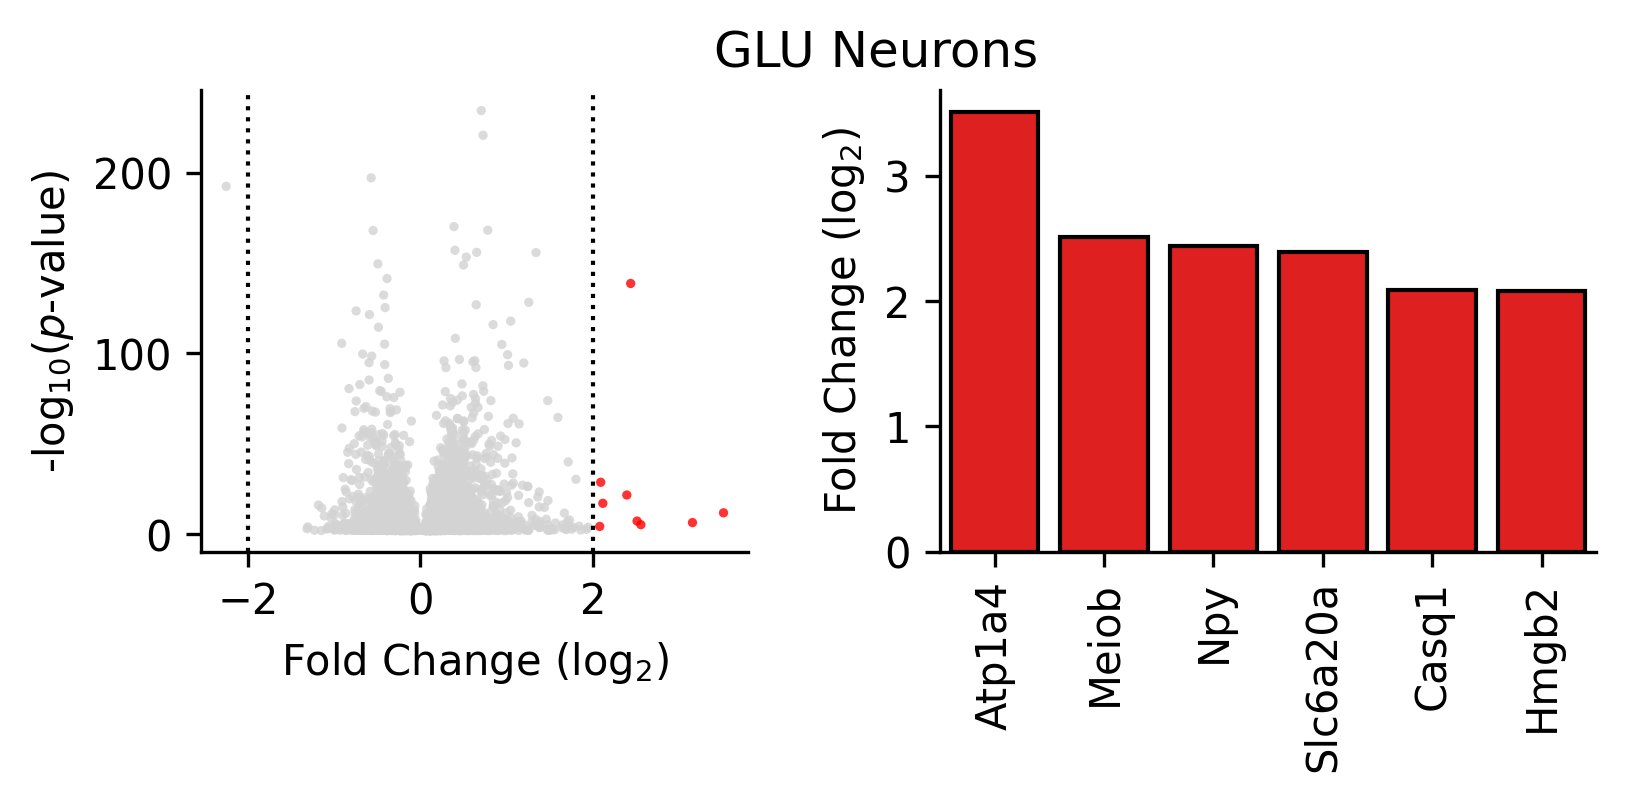

         names     scores  logfoldchanges          pvals      pvals_adj  \
810     Atp1a4   7.067988        3.514216   1.571959e-12   3.082417e-11   
1368     Meiob   5.424137        2.511599   5.823529e-08   6.829089e-07   
9          Npy  25.136889        2.437438  1.966114e-139  3.079426e-136   
391   Slc6a20a   9.731638        2.392973   2.210057e-22   8.961816e-21   
249      Casq1  11.263664        2.090118   1.983373e-29   1.191927e-27   
2060     Hmgb2   4.041414        2.078266   5.312988e-05   4.143899e-04   

          log10p color  
810    11.803559     r  
1368    7.234814     r  
9     138.706391     r  
391    21.655597     r  
249    28.702596     r  
2060    4.274661     r  



In [14]:
""" By cell type """

alpha = 0.05
plot_top = 10
lcft = 2
key = 'Diet'

ctypes = [
    ' GABA',
    ' GLU',
    
]

for ctype in ctypes:
    tmp = sun[sun.obs["broad_type"] == ctype] 

    # get marker genes
    sc.tl.rank_genes_groups(tmp, 
                            groupby=key,
                            method='wilcoxon',
                            key_added=key,
                            corr_method='benjamini-hochberg')



    deg = sc.get.rank_genes_groups_df(tmp, 
                                      group='fasted',
                                      key=key)
    
    deg['log10p'] = -1 * np.log10(deg['pvals'])
    deg = deg[deg['pvals_adj'] <= alpha]
    deg['color'] = np.where(deg['logfoldchanges'] > lcft, 'r', 'lightgrey')

    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['figure.figsize'] = 6, 2
    
    sns.scatterplot(data=deg, 
                x='logfoldchanges',
                y='log10p',
                ec='none',
                alpha=0.8,
                c=deg['color'].to_list(),
                zorder=1,
                s=5)

    plt.ylabel(r"-log$_{10}$($p$-value)")
    plt.xlabel(r"Fold Change (log$_{2}$)")
    
    
    plt.axvline(x=2, lw=1, c='k', ls=':', zorder=2)
    plt.axvline(x=-2, lw=1, c='k', ls=':', zorder=2)
    
    hi_deg = deg[deg['logfoldchanges'] > lcft]
    hi_deg = hi_deg[~hi_deg['names'].str.contains('Gm')]
    hi_deg = hi_deg.sort_values(by='logfoldchanges', ascending=False)
    hi_deg = hi_deg.head(plot_top)
    
    divider = make_axes_locatable(plt.gca())
    ax2 = divider.append_axes("right", size="120%", pad="35%")
    
    sns.barplot(data=hi_deg,
                y='logfoldchanges',
                x='names',
                ec='k',
                color='r',
                ax=ax2)
    
    ax2.set_ylabel(r"Fold Change (log$_{2}$)")
    ax2.set_xlabel("")
    ax2.tick_params(axis='x', rotation=90)
    
    sns.despine()
    plt.suptitle(f"{ctype.strip()} Neurons")
    plt.show()
    
    print(hi_deg)
    print()
    # break

/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


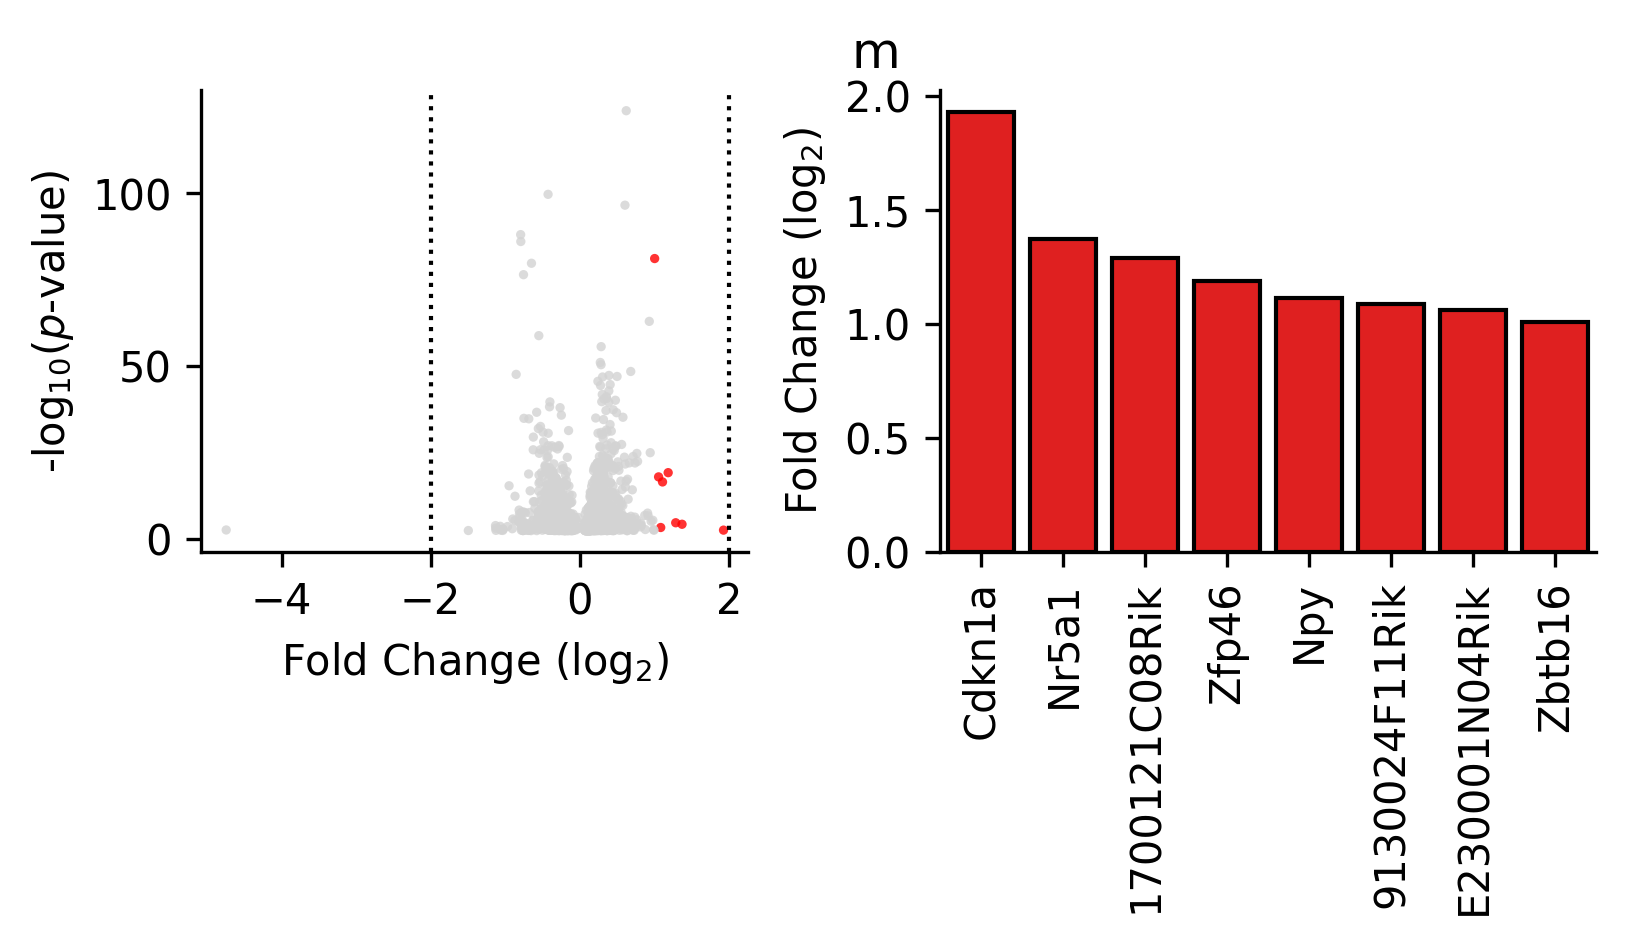

              names     scores  logfoldchanges         pvals     pvals_adj  \
1508         Cdkn1a   2.924817        1.930059  3.446591e-03  3.645908e-02   
888           Nr5a1   3.980841        1.373122  6.867198e-05  1.264285e-03   
790   1700121C08Rik   4.212086        1.288520  2.530228e-05  5.297203e-04   
92            Zfp46   9.116855        1.187177  7.733643e-20  1.374504e-17   
123             Npy   8.420023        1.111370  3.764107e-17  4.964659e-15   
1144  9130024F11Rik   3.432908        1.087280  5.971439e-04  8.318192e-03   
103   E230001N04Rik   8.806034        1.058631  1.296511e-18  2.030660e-16   
2            Zbtb16  19.166267        1.005827  7.080983e-82  2.534992e-78   

         log10p color  
1508   2.462610     r  
888    4.163220     r  
790    4.596840     r  
92    19.111616     r  
123   16.424338     r  
1144   3.223921     r  
103   17.887224     r  
2     81.149906     r  



/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


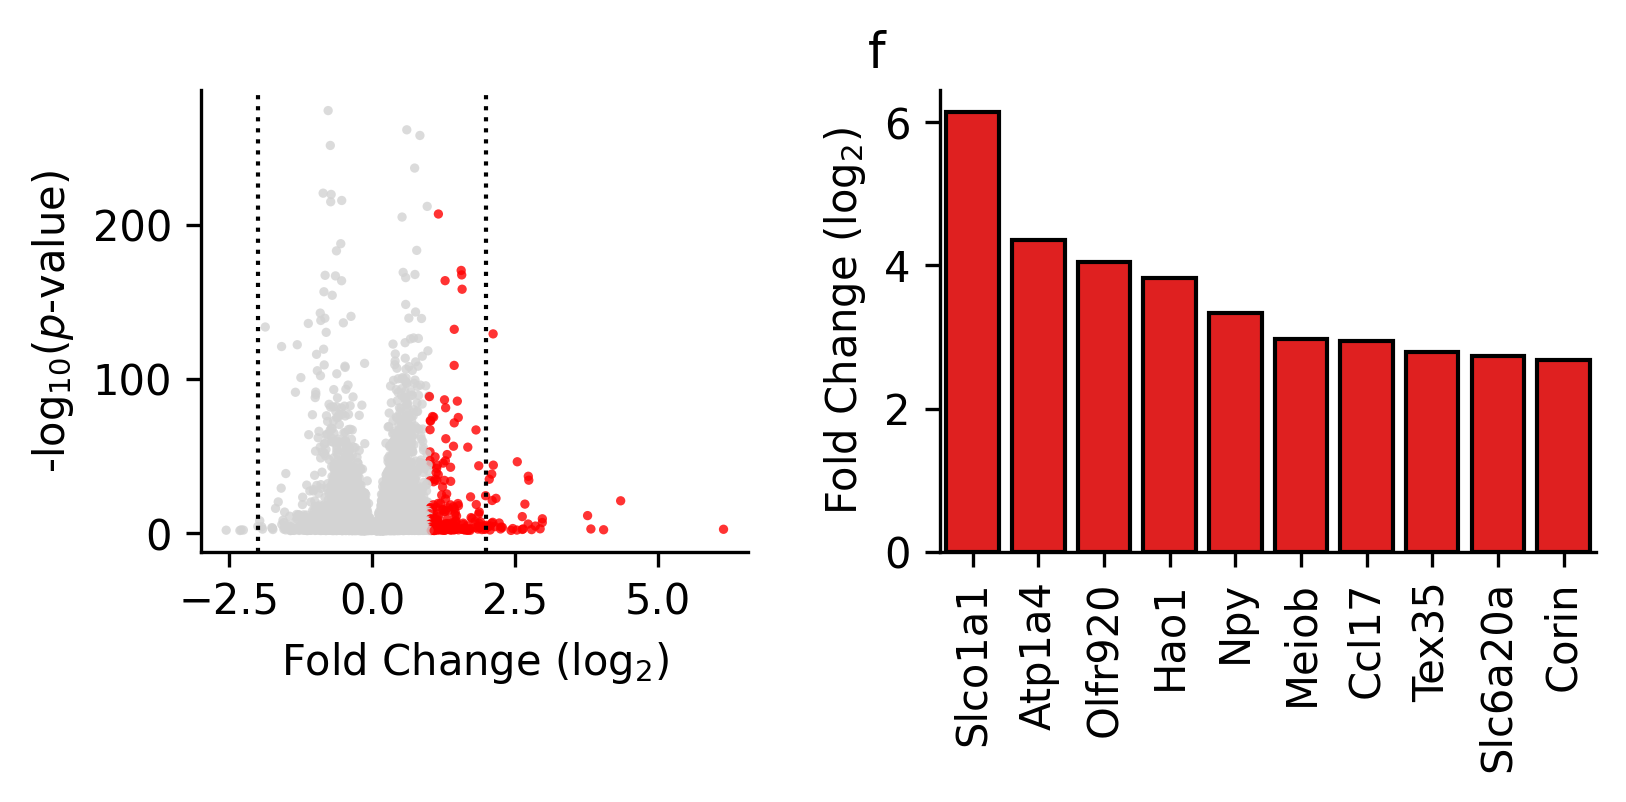

         names     scores  logfoldchanges         pvals     pvals_adj  \
4003   Slco1a1   3.096892        6.150770  1.955611e-03  8.367356e-03   
859     Atp1a4   9.611081        4.349504  7.179099e-22  1.501738e-20   
4227   Olfr920   2.876834        4.050931  4.016869e-03  1.624504e-02   
3873      Hao1   3.222858        3.828319  1.269184e-03  5.610471e-03   
0          Npy  39.786247        3.340357  0.000000e+00  0.000000e+00   
1860     Meiob   6.290948        2.978447  3.155321e-10  3.034242e-09   
3798     Ccl17   3.297659        2.939500  9.749440e-04  4.405110e-03   
4164     Tex35   2.939581        2.790826  3.286564e-03  1.351293e-02   
395   Slc6a20a  12.841470        2.732378  9.603317e-38  4.259454e-36   
971      Corin   9.089790        2.672720  9.923022e-20  1.827119e-18   

         log10p color  
4003   2.708718     r  
859   21.143930     r  
4227   2.396112     r  
3873   2.896475     r  
0           inf     r  
1860   9.500956     r  
3798   3.011020     r  
4164

In [15]:
""" By sex """

alpha = 0.05
plot_top = 10
lcft = 1
key = 'Diet'

sexes = ['m','f',]

for sex in sexes:
    tmp = sun[sun.obs["Sex"] == sex] 

    # get marker genes
    sc.tl.rank_genes_groups(tmp, 
                            groupby=key,
                            method='wilcoxon',
                            key_added=key,
                            corr_method='benjamini-hochberg')


    deg = sc.get.rank_genes_groups_df(tmp, 
                                      group='fasted',
                                      key=key)
    
    deg['log10p'] = -1 * np.log10(deg['pvals'])
    deg = deg[deg['pvals_adj'] <= alpha]
    deg['color'] = np.where(deg['logfoldchanges'] > lcft, 'r', 'lightgrey')

    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['figure.figsize'] = 6, 2
    
    sns.scatterplot(data=deg, 
                x='logfoldchanges',
                y='log10p',
                ec='none',
                alpha=0.8,
                c=deg['color'].to_list(),
                zorder=1,
                s=5)

    plt.ylabel(r"-log$_{10}$($p$-value)")
    plt.xlabel(r"Fold Change (log$_{2}$)")
    
    
    plt.axvline(x=2, lw=1, c='k', ls=':', zorder=2)
    plt.axvline(x=-2, lw=1, c='k', ls=':', zorder=2)
    
    hi_deg = deg[deg['logfoldchanges'] > lcft]
    hi_deg = hi_deg[~hi_deg['names'].str.contains('Gm')]
    hi_deg = hi_deg.sort_values(by='logfoldchanges', ascending=False)
    hi_deg = hi_deg.head(plot_top)
    
    divider = make_axes_locatable(plt.gca())
    ax2 = divider.append_axes("right", size="120%", pad="35%")
    
    sns.barplot(data=hi_deg,
                y='logfoldchanges',
                x='names',
                ec='k',
                color='r',
                ax=ax2)
    
    ax2.set_ylabel(r"Fold Change (log$_{2}$)")
    ax2.set_xlabel("")
    ax2.tick_params(axis='x', rotation=90)
    
    sns.despine()
    plt.suptitle(f"{sex.strip()}")
    plt.show()
    
    print(hi_deg)
    print()
    # break

In [16]:
# # db = 'GO_Biological_Process_2023'
# db = 'GO_Biological_Process_2021'
# # db = 'KEGG_2021_Human'
# # db = 'TRANSFAC_and_JASPAR_PWMs'

# e_alpha = 0.05

# edf = gget.enrichr(sigf['names'].head(n_query).to_list(), database=db)
# # edf = edf[edf['adj_p_val'] <= e_alpha]
# pd.set_option('display.max_colwidth', 150)
# print(edf[['path_name', 'adj_p_val', 'overlapping_genes']])
# print()


In [17]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
""" Distribution of marker gene expression """
query = [
    'Slc1a2',
    'Slc7a10',
    'Slc39a12',
    'Itih3',
    'Gad1',
    'Gad2',
    'Gabbr2',
    'Grin2b',
    'Slc17a6',
    'Aim2',
    'P2rx7',
    'Il10ra',
    'Ninj2',
    'Sec14l5', 
    'Drd2', 
    'Mest',
]


"""Extract expression for marker genes """
mask = (adata.obs['sun1'] == 1)
pos_ind = adata.obs[mask].index.to_list()
neg_ind = adata.obs[~mask].index.to_list()

pos = adata[pos_ind, query].to_df()
neg = adata[neg_ind, query].to_df()

print(f"{pos.shape=} {neg.shape=}")

pdf = pd.concat([pos, neg])

pdf = pd.merge(pdf, adata.obs,
               how='left',
               left_index=True,
               right_index=True)

print(f"{pdf.shape}")
                
pdf.head()

In [ ]:
""" Distribution of marker gene expression """
query = [
    'Mc3r', 
    "Agrp", 
    "Npy", 
    "Nr5a1", 
    "Pomc", 
    "Mc4r", 
    "Gnrhr", 
    "Gnrh1", 
    "Ghrh", 
    "Ghrhr", 
    "Sst", 
    "Esr1",
    "Lepr",
    "Pnoc",
    "Adcyap1",
    "Foxp2", 
    "Dlk1",
    "Kiss1", 
    "Tac2", 
    "Pdyn", 
    "Rprm",
    "Oxtr",
    "Drd2",
    "Gria3", 
    "Grik1", 
    "Grik3", 
    "Gabra5", 
    "Gabra2", 
    "Syndig1",
    "Pak3",
    "Ptk2b", 
    "Plk2",
    "Trh",
    "Glp1r",
]



In [ ]:
# db = 'GO_Biological_Process_2023'
db = 'GO_Biological_Process_2021'
# db = 'KEGG_2021_Human'
# db = 'TRANSFAC_and_JASPAR_PWMs'

e_alpha = 0.05

edf = gget.enrichr(list(new_query['gene'].unique()), database=db)
edf = edf[edf['adj_p_val'] <= e_alpha]
pd.set_option('display.max_colwidth', 150)
edf[['path_name', 'adj_p_val', 'overlapping_genes']]

In [ ]:
break

In [ ]:
break